# QHACK's Quantum Chemistry Challenge

This is Constantine Quantum Technologies's solution to QHACK's Quantum Chemistry Challenge. The challenge asks to calculate the ground state of the $BeH2$ molecule using quantum computational methods.

**Team**:
- Abdellah Tounsi
- Mohamed Messaoud Louamri
- Nacer eddine Belaloui

**Setup**:
⚠️ _(make sure to have all the packages installed and up-to-date!)_

In [1]:
# !pip install qiskit qiskit_nature pyscf qiskit_ibm_runtime --upgrade --quiet

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

from qiskit import compiler
from qiskit.providers.fake_provider import FakeGuadalupeV2

from qiskit.primitives import BackendEstimator
from qiskit.algorithms import MinimumEigensolverResult

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.circuit.library import UCC
from qiskit.circuit.library import EfficientSU2

from qiskit.algorithms.optimizers import SPSA

from qiskit_nature.settings import settings

settings.dict_aux_operators = True


In [76]:
import qiskit.tools.jupyter
%qiskit_version_table

## Defining the problem

To represent wave functions and Hamiltonians in quantum chemistry problems such as the one we are tackling in QHack 2023, we need to use a set of atomic orbitals functions which will serve as a basis set for our quantum states. These are used to approximate and compute solutions for molecular problems in quantum chemistry. Specifically, in our challenge, the problem is to find the ground state energy of the BeH2 molecule. 

There exists a variety of basis sets one can use in quantum chemistry, each offering advantages and disadvantages, which depend on the nature of the molecule to be studied. We can cite three examples here, which are suitable for small, medium, and large molecules: 

The STO-3G basis set is one of the simplest options that is widely used for small molecules. It uses three Gaussian functions that create Slater-type orbitals through a linear combination. It gives reliable results in a short amount of time, but it is not precise enough for larger molecules. 

The 6-31G basis set is used for medium-sized molecules. This basis set utilizes two sets of functions, one for the core electrons (6 Gaussian functions) and the other for the valence electrons (31 Gaussian functions), thus its name. It provides more accuracy than STO-3G but will require more computational power. 

The cc-pVDZ basis set is a larger set that is suitable for larger molecules. This basis set employs polarization functions to enhance the accuracy of the calculations and includes multiple sets of functions for different atom types, comprising both Gaussian and polarization functions. It is more computationally demanding than both STO-3G and 6-31G but is significantly more accurate.

Once the basis set was chosen and the Hamiltonian for the problem at hand is formalized, we need to take it from a form that is suitable for analytical and classical numerical computations to one that can be implemented on a quantum computer. For this task, we must transform the quantum operators of the Hamiltonian into Pauli operators which can be executed in a quantum circuit. 

Methods have already been developed to address this need, the most popular being the parity mapping, Jordan-Wigner mapping, and Bravyi-Kitaev mapping. All of these three mappings are implemented in Qiskit. 

In what follows, we will try to compare different basis and different mappings and pick the one which seems better to solve our task.

### Hamiltonian Encoding

In [77]:
def hamiltonian_encoding(basis):
    value = 1.326
    beh2_geo = [["H", [value, 0.0, 0.0]],
                    ["Be", [0.0, 0.0, 0.0]],
                    ["H", [-value, 0.0, 0.0]]]

    beh2 = Molecule( 
          geometry=beh2_geo
      )

    driver = ElectronicStructureMoleculeDriver(beh2, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    properties = driver.run()

    problem = ElectronicStructureProblem(driver) 
    _ = problem.second_q_ops()

    return problem

In [78]:
encoders_list = ['Parity', 'ParityWithReduction', 'JordanWigner', 'BravyiKitaev']

def map_problem(problem, method: str):
    if method == 'Parity' or method == 'ParityWithReduction':
        encoder = ParityMapper()
    elif method == 'JordanWigner':
        encoder = JordanWignerMapper()
    elif method == 'BravyiKitaev':
        encoder = BravyiKitaevMapper()
    else:
        raise Exception("Unknown mapping function")
    
    converter = QubitConverter(encoder, two_qubit_reduction=(method=='ParityWithReduction'))
    qubit_op = converter.convert(problem.second_q_ops()["ElectronicEnergy"], num_particles=problem.num_particles)
    return converter, qubit_op

In [79]:
print("For STO-3G:")
print("-----------\n")
problem = hamiltonian_encoding("sto3g")
print("The number of spin orbitals is", problem.num_spin_orbitals, '\n')

for encoder in encoders_list:
    _, qubit_op_ = map_problem(problem, encoder)
    print(f"{encoder} mapping requires {qubit_op_.num_qubits} qubits and the calculation of {len(qubit_op_.coeffs)} terms")

For STO-3G:
-----------

The number of spin orbitals is 14 

Parity mapping requires 14 qubits and the calculation of 666 terms
ParityWithReduction mapping requires 12 qubits and the calculation of 666 terms
JordanWigner mapping requires 14 qubits and the calculation of 666 terms
BravyiKitaev mapping requires 14 qubits and the calculation of 666 terms


In [80]:
print("For 6-31G:")
print("----------\n")
problem = hamiltonian_encoding("6-31g")
print("The number of spin orbitals is", problem.num_spin_orbitals, '\n')

for encoder in encoders_list:
    _, qubit_op_ = map_problem(problem, encoder)
    print(f"{encoder} mapping requires {qubit_op_.num_qubits} qubits and the calculation of {len(qubit_op_.coeffs)} terms")

For 6-31G:
----------

The number of spin orbitals is 26 

Parity mapping requires 26 qubits and the calculation of 9204 terms
ParityWithReduction mapping requires 24 qubits and the calculation of 9204 terms
JordanWigner mapping requires 26 qubits and the calculation of 9204 terms
BravyiKitaev mapping requires 26 qubits and the calculation of 9204 terms


In [151]:
print("For CC-PVDZ:")
print("------------\n")
problem = hamiltonian_encoding("ccpvdz")
print("The number of spin orbitals is", problem.num_spin_orbitals, '\n')

for encoder in encoders_list:
    _, qubit_op_ = map_problem(problem, encoder)
    print(f"{encoder} mapping requires {qubit_op_.num_qubits} qubits and the calculation of {len(qubit_op_.coeffs)} terms")

For CC-PVDZ:
------------

The number of spin orbitals is 48 

Parity mapping requires 48 qubits and the calculation of 102713 terms
ParityWithReduction mapping requires 46 qubits and the calculation of 102681 terms
JordanWigner mapping requires 48 qubits and the calculation of 102713 terms
BravyiKitaev mapping requires 48 qubits and the calculation of 102713 terms


<hr/>
Even though it may be clear that the STO-3G basis set is the most suitable for the BeH2 molecule, the combination of the basis set and the mapping may not be as clear. For this, we provide a few numbers on the Hamiltonians that different sets with different mappings give in Qiskit: 

1. **STO-3G** 
    - The number of spin orbitals is 14 (and thus it requires 14 qubits)  
    - Parity mapping requires 14 qubits and the calculation of 666 terms 
    - ParityWithReduction mapping requires 12 qubits and the calculation of 666 terms 
    - JordanWigner mapping requires 14 qubits and the calculation of 666 terms 
    - BravyiKitaev mapping requires 14 qubits and the calculation of 666 terms 
1. **6-31G** 
    - The number of spin orbitals is 26  (and thus it requires 26 qubits)  
    - Parity mapping requires 26 qubits and the calculation of 9204 terms 
    - ParityWithReduction mapping requires 24 qubits and the calculation of 9204 terms 
    - JordanWigner mapping requires 26 qubits and the calculation of 9204 terms 
    - BravyiKitaev mapping requires 26 qubits and the calculation of 9204 terms 
1. **cc-pVDZ** 
    - The number of spin orbitals is 48 (and thus it requires 48 qubits)  
    - Parity mapping requires 48 qubits and the calculation of 102713 terms
    - ParityWithReduction mapping requires 46 qubits and the calculation of 102681 terms
    - JordanWigner mapping requires 48 qubits and the calculation of 102713 terms
    - BravyiKitaev mapping requires 48 qubits and the calculation of 102713 terms

It is now obvious that the STO-3G basis set with a parity mapping, in addition to the reduction of 2 qubits is what we need for BeH2, with the devices that we have, or that we can simulate. 

### Ansatz

The variational method in quantum mechanics, and by extension the variational quantum eigensolver, relies on a trial quantum state to be the, or close to the exact solution for a given Hamiltonian. The Ritz theorem ensures that for any arbitrary trial quantum state (or wavefunction), the expectation value of the Hamiltonian with respect to the trial state is always greater or equal to the ground state energy of that Hamiltonian, with closer states to the actual Hamiltonian ground state giving closer expectation values to the ground state energy. Therefore, in the VQE, the trial state, called the ansatz, must be as physically accurate as possible to obtain precise results. However, these types of states are usually complex when expressed as a quantum circuit. 

We are now faced with the problem of choosing between an ansatz that is theoretically more accurate, or one that is easier to implement, and less susceptible to noise during the computation. In quantum chemistry, the choice is usually between the UCCSD ansatz that is chemically inspired, and a hardware efficient ansatz that considers the specificities of current quantum computers. 

In the UCCSD ansatz, the electronic wavefunction of the molecule is expressed as a linear combination of single and double excitations of the reference wavefunction, which is typically the Hartree-Fock wavefunction. The amplitudes of these excitations are then optimized to minimize the molecule's electronic energy. 

The hardware efficient ansatz is a type of ansatz that is designed to be computationally efficient and suitable for implementation on near-term quantum devices with limited connectivity and gate fidelities. The quantum circuit of such ansätze is typically composed of alternating layers of single-qubit rotations and two-qubit interactions.

In what follows, we will compare the ansatze depth and the number of 2 qubit gates that it requires.

In [81]:
problem = hamiltonian_encoding("sto3g")
converter, qubit_op = map_problem(problem, 'ParityWithReduction')

In [82]:
uccsd_raw = UCC(
    qubit_converter=converter,
    num_particles=problem.num_particles, 
    num_spin_orbitals=problem.num_spin_orbitals,
    excitations='sd'
)

In [83]:
transpiled = compiler.transpile(uccsd_raw, FakeGuadalupeV2(), optimization_level=2)

In [84]:
transpiled.depth()

27618

In [85]:
ops = transpiled.count_ops()

In [86]:
print(ops.get('cx'))

25729


In [87]:
hea_raw =  EfficientSU2(qubit_op.num_qubits, reps=1, entanglement='circular')

In [88]:
transpiled = compiler.transpile(hea_raw, FakeGuadalupeV2(), optimization_level=2)

In [89]:
transpiled.depth()

24

In [90]:
ops = transpiled.count_ops()

In [91]:
print(ops.get('cx'))

12


We can see that HEA is way lighter than UCCSD and that we cannot hope to execute the UCCSD ansatze on current devices and obtain a meaningful result (due to the excessive depth and the excessive number of two qubits gate).

Finally, we need to choose an optimizer for our hybrid task. For this one, we will follow [Kandala et al](https://www.nature.com/articles/nature23879). the SPSA optimizer because it requires less number of jobs and is more adapted to noisy problems. SPSA requires 50 jobs in the calibration phase and then it optimizes with 3 jobs for each iteration.

Sadly, we couldn't run the code for the problem as is with Parity encoding and HAE due to time restrictions. During our trials, we observed that each job takes approximatively 5m50s to finish and thus to perform a full VQE run with 300 iterations for example we would need 92+ hours which is approximately 4 full days:

<img src="images/ibmq_guadalupe_time.jpg" alt="Time it took for a single job to execute on IBMQ Guadalupe" />

In [168]:
# For 300 iterations with SPSA, it requires (50 jobs calibration and 3 jobs per iteration)
time_spent_per_job = 5 * 60 + 51 # seconds from 2 data point
nb_of_jobs = 300 * 3 + 50

print(f"Estimated time to run the full VQE iteration is {time_spent_per_job * nb_of_jobs} seconds")

# Which is more than 92 hours (approximately 4 full days)

Estimated time to run the full VQE iteration is 333450 seconds


## Simplifying the problem

To simplify the problem and be able to run it and get a meaningful result in a reasonable time, we will assume that inner spin orbitals are full and frozen, and do not contribute significantly to the dynamics of the molecule.

In [153]:
def hamiltonian_encoding_simplified(basis):
    value = 1.326
    beh2_geo = [["H", [value, 0.0, 0.0]],
                ["Be", [0.0, 0.0, 0.0]],
                ["H", [-value, 0.0, 0.0]]]

    beh2 = Molecule( 
      geometry=beh2_geo
    )

    driver = ElectronicStructureMoleculeDriver(beh2, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    properties = driver.run()

    transformer_1 = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3
    )

    problem = ElectronicStructureProblem(driver, transformers=[transformer_1]) 
    _ = problem.second_q_ops()

    return problem

In [154]:
print("For STO-3G:")
print("-----------\n")
problem = hamiltonian_encoding_simplified("sto3g")
print()
print("The number of spin orbitals is", problem.num_spin_orbitals, '\n')

for encoder in encoders_list:
    _, qubit_op_ = map_problem(problem, encoder)
    print(f"{encoder} mapping requires {qubit_op_.num_qubits} qubits and the calculation of {len(qubit_op_.coeffs)} terms")

For STO-3G:
-----------


The number of spin orbitals is 6 

Parity mapping requires 6 qubits and the calculation of 34 terms
ParityWithReduction mapping requires 4 qubits and the calculation of 28 terms
JordanWigner mapping requires 6 qubits and the calculation of 34 terms
BravyiKitaev mapping requires 6 qubits and the calculation of 34 terms


As we can see above, we end up with a Hamiltonian that can be encoded in 4 qubits, and having only 28 terms, if we employ the ParityWithReduction mapping and the STO-3G basis set.

### Choosing the ansatz

We will choose between 2 possible ansäte, namely the UCCSD and the EfficientSU2.

#### UCCSD

In [155]:
problem = hamiltonian_encoding_simplified("sto3g")
converter, qubit_op = map_problem(problem, 'ParityWithReduction')

In [156]:
uccsd_simplified = UCC(
    qubit_converter=converter,
    num_particles=problem.num_particles, 
    num_spin_orbitals=problem.num_spin_orbitals,
    excitations='sd'
)

In [157]:
transpiled = compiler.transpile(uccsd_simplified, FakeGuadalupeV2(), optimization_level=2)

In [158]:
transpiled.depth()

270

For the chemically inspired UCCSD ansatz, we get a trial state circuit with a depth of 270.

In [159]:
ops = transpiled.count_ops()

In [160]:
print(ops.get('cx'))

181


Just as important as the depth, the number of 2-qubit gates (CNOTs in this case) is 181!

#### EfficientSU2

In [161]:
hea_simplified =  EfficientSU2(qubit_op.num_qubits, reps=1, entanglement='circular')

In [162]:
transpiled = compiler.transpile(hea_simplified, FakeGuadalupeV2(), optimization_level=2)

In [163]:
transpiled.depth()

25

Since the EfficientSU2 ansatz is hardware efficient (as the name implies), we only get a depth of 25!

In [164]:
ops = transpiled.count_ops()

In [165]:
print(ops.get('cx'))

7


And even better, we only need to use 7 CNOTs.

## Executing

In the folowing sections, we will compare different VQEs, either simulated or on a real IBMQ device, for the $BeH_2$ molecule.

For convenience, we have saved the data of all of our simulations and real device results, which we have pre-loaded in the notebook.

### Ideal device
Here we simulate an ideal quantum device, unaffected by noise, on which we execute a VQE circuit to compute the ground energy of $BeH2$.<br>
We will use the QASM Simulator provided in Qiskit.

In [106]:
from qiskit import Aer

backend_ideal = Aer.get_backend("qasm_simulator")
options = {}

In [107]:
def train_local(problem, observables, ansatz, backend, options, initial_point=None):
    estimator = BackendEstimator(backend=backend, options=options)
    energies = []
    param_history = []
    job_list = []
    prev_jobs = 0
    last_time = time()
    nb_iter = 0
    
    def evaluate_expectation(x):
        x = list(x)
        job = estimator.run(circuits=[ansatz], parameter_values=[x], observables=[observables]).result()
        results = job.values[0]
        job_list.append(job)
    
        return np.real(results)

    def callback(x, fx, ax, tx, nx):
        nonlocal prev_jobs, last_time, nb_iter
        
        sol = MinimumEigensolverResult()
        sol.eigenvalue = ax
        energies.append(np.real(problem.interpret(sol).total_energies[0]))
        param_history.append(fx)
        print(f"[{len(energies)}] Current estimate: {energies[-1]:.5f}  Ha")
        prev_jobs = len(job_list)
        last_time = time() 

    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    optimizer =  SPSA(maxiter=200, callback=callback)
    result =  optimizer.minimize(evaluate_expectation, x0=initial_point)
   
    return energies, param_history

#### UCCSD

In [108]:
# energies_ideal_uccsd, params_ideal_uccsd = train_local(problem, qubit_op, uccsd_simplified, backend_ideal, options, initial_point=None)

[1] Current estimate: -15.23220  Ha
[2] Current estimate: -15.25714  Ha
[3] Current estimate: -15.23936  Ha
[4] Current estimate: -15.28500  Ha
[5] Current estimate: -15.26953  Ha
[6] Current estimate: -15.27163  Ha
[7] Current estimate: -15.31484  Ha
[8] Current estimate: -15.28220  Ha
[9] Current estimate: -15.29898  Ha
[10] Current estimate: -15.28378  Ha
[11] Current estimate: -15.32111  Ha
[12] Current estimate: -15.31617  Ha
[13] Current estimate: -15.29227  Ha
[14] Current estimate: -15.30578  Ha
[15] Current estimate: -15.30962  Ha
[16] Current estimate: -15.33568  Ha
[17] Current estimate: -15.36475  Ha
[18] Current estimate: -15.37106  Ha
[19] Current estimate: -15.42630  Ha
[20] Current estimate: -15.49989  Ha
[21] Current estimate: -15.38590  Ha
[22] Current estimate: -15.42190  Ha
[23] Current estimate: -15.37659  Ha
[24] Current estimate: -15.39687  Ha
[25] Current estimate: -15.36516  Ha
[26] Current estimate: -15.44019  Ha
[27] Current estimate: -15.43517  Ha
[28] Curre

In [116]:
# np.save(Path.cwd() / "data" / "energies_ideal_uccsd", np.array(energies_ideal_uccsd))

In [117]:
energies_ideal_uccsd = np.load(Path.cwd() / "data" / "energies_ideal_uccsd.npy")

#### HAE

In [118]:
# energies_ideal_hea, params_ideal_hea = train_local(problem, qubit_op, hea_simplified, backend_ideal, options, initial_point=None)

[1] Current estimate: -14.53228  Ha
[2] Current estimate: -14.65635  Ha
[3] Current estimate: -14.98543  Ha
[4] Current estimate: -15.29318  Ha
[5] Current estimate: -15.23882  Ha
[6] Current estimate: -15.24696  Ha
[7] Current estimate: -15.24926  Ha
[8] Current estimate: -15.27740  Ha
[9] Current estimate: -15.27777  Ha
[10] Current estimate: -15.29332  Ha
[11] Current estimate: -15.27031  Ha
[12] Current estimate: -15.34318  Ha
[13] Current estimate: -15.35112  Ha
[14] Current estimate: -15.37912  Ha
[15] Current estimate: -15.39204  Ha
[16] Current estimate: -15.40048  Ha
[17] Current estimate: -15.42656  Ha
[18] Current estimate: -15.41198  Ha
[19] Current estimate: -15.50244  Ha
[20] Current estimate: -15.51862  Ha
[21] Current estimate: -15.52382  Ha
[22] Current estimate: -15.52040  Ha
[23] Current estimate: -15.53541  Ha
[24] Current estimate: -15.54757  Ha
[25] Current estimate: -15.54498  Ha
[26] Current estimate: -15.55191  Ha
[27] Current estimate: -15.55236  Ha
[28] Curre

In [132]:
# np.save(Path.cwd() / "data" / "energies_ideal_hea", np.array(energies_ideal_hea))

In [133]:
energies_ideal_hea = np.load(Path.cwd() / "data" / "energies_ideal_hea.npy")

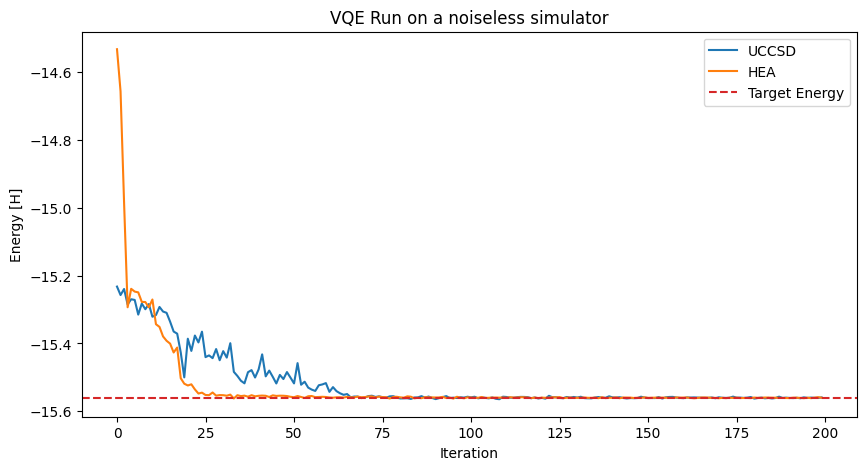

In [136]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(energies_ideal_uccsd, label="UCCSD")
plt.plot(energies_ideal_hea, label="HEA")

plt.axhline(y=-15.561353, color="tab:red", ls="--", label="Target Energy")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE Run on a noiseless simulator")
plt.show()

In the plots above, we can see that both ansätze converged perfectly towards the know ground energy for $BeH_2$. This is expected as the simulated device is perfect and noise-free.

### Noisy device

Of course, real device are far from being noise-free. Thus, a more suitable simulation must include the effects of noise. We use a noise model from the IBMQ Guadalupe quantum device, as this is the device on which we ran our real experiment.

Here, we only optimize the circuit for the device, without using any error mitigation techniques.

In [138]:
from qiskit.providers.fake_provider import FakeGuadalupeV2
backend_noisy = FakeGuadalupeV2()
options = {
    'optimization_level': 2
}

#### UCCSD

In [139]:
# energies_noisy_uccsd, params_noisy_uccsd = train_local(problem, qubit_op, uccsd_simplified, backend_noisy, options, initial_point=None)

[1] Current estimate: -14.67849  Ha
[2] Current estimate: -14.74394  Ha
[3] Current estimate: -14.72557  Ha
[4] Current estimate: -14.72960  Ha
[5] Current estimate: -14.66908  Ha
[6] Current estimate: -14.72879  Ha
[7] Current estimate: -14.69739  Ha
[8] Current estimate: -14.75272  Ha
[9] Current estimate: -14.71542  Ha
[10] Current estimate: -14.75049  Ha
[11] Current estimate: -14.69068  Ha
[12] Current estimate: -14.74111  Ha
[13] Current estimate: -14.77009  Ha
[14] Current estimate: -14.72828  Ha
[15] Current estimate: -14.76121  Ha
[16] Current estimate: -14.82154  Ha
[17] Current estimate: -14.80405  Ha
[18] Current estimate: -14.80227  Ha
[19] Current estimate: -14.73707  Ha
[20] Current estimate: -14.76477  Ha
[21] Current estimate: -14.79593  Ha
[22] Current estimate: -14.83975  Ha
[23] Current estimate: -14.75464  Ha
[24] Current estimate: -14.77834  Ha
[25] Current estimate: -14.79898  Ha
[26] Current estimate: -14.79392  Ha
[27] Current estimate: -14.74298  Ha
[28] Curre

In [140]:
# np.save(Path.cwd() / "data" / "energies_noisy_uccsd", np.array(energies_noisy_uccsd))

In [141]:
energies_noisy_uccsd = np.load(Path.cwd() / "data" / "energies_noisy_uccsd.npy")

#### HAE

In [142]:
# energies_noisy_hea, params_noisy_hea = train_local(problem, qubit_op, hea_simplified, backend_noisy, options, initial_point=None)

[1] Current estimate: -15.01898  Ha
[2] Current estimate: -14.94731  Ha
[3] Current estimate: -14.92859  Ha
[4] Current estimate: -14.98216  Ha
[5] Current estimate: -15.03206  Ha
[6] Current estimate: -15.03157  Ha
[7] Current estimate: -15.10076  Ha
[8] Current estimate: -15.10499  Ha
[9] Current estimate: -15.09066  Ha
[10] Current estimate: -15.09775  Ha
[11] Current estimate: -15.13476  Ha
[12] Current estimate: -15.14125  Ha
[13] Current estimate: -15.13146  Ha
[14] Current estimate: -15.13128  Ha
[15] Current estimate: -15.17395  Ha
[16] Current estimate: -15.16974  Ha
[17] Current estimate: -15.17216  Ha
[18] Current estimate: -15.15622  Ha
[19] Current estimate: -15.16404  Ha
[20] Current estimate: -15.16037  Ha
[21] Current estimate: -15.20813  Ha
[22] Current estimate: -15.14377  Ha
[23] Current estimate: -15.15840  Ha
[24] Current estimate: -15.17886  Ha
[25] Current estimate: -15.18375  Ha
[26] Current estimate: -15.21295  Ha
[27] Current estimate: -15.24205  Ha
[28] Curre

In [143]:
# np.save(Path.cwd() / "data" / "energies_noisy_hea", np.array(energies_noisy_hea))

In [144]:
energies_noisy_hea = np.load(Path.cwd() / "data" / "energies_noisy_hea.npy")

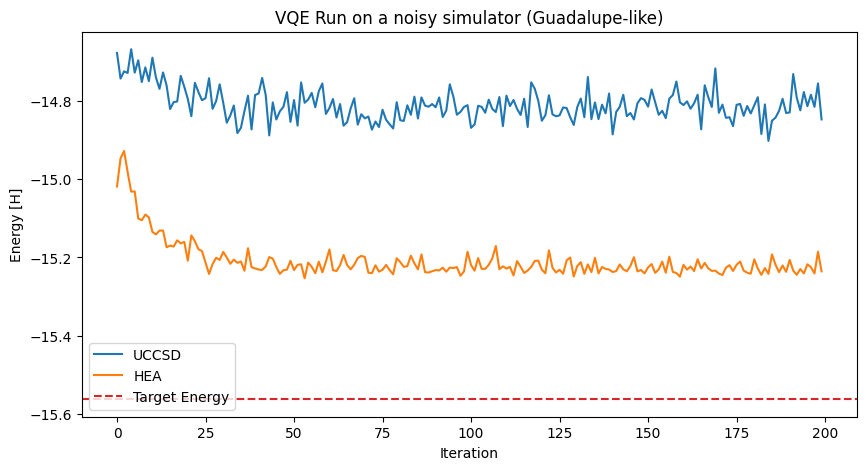

In [145]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(energies_noisy_uccsd, label="UCCSD")
plt.plot(energies_noisy_hea, label="HEA")

plt.axhline(y=-15.561353, color="tab:red", ls="--", label="Target Energy")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE Run on a noisy simulator (Guadalupe-like)")
plt.show()

Unlike the previous simulation, in a noisy device, we can first of all see than neither of the circuits has found the correct energy, although there is a clear winner between the two, which is the hardware efficient ansatz, the noise having affected the UCCSD circuit much more than the EfficientSU2 for the reasons explained above.

### Noisy device (with Error Mitigation)

Now let us apply error mitigation on our noisy VQE simulation. We used the level 3 error mitigation in Qiskit primitives which uses PEC, with the same level of optimization.

In [146]:
options = {
    'optimization_level': 2,
    'resilience_level': 3
}

#### UCCSD

In [147]:
# energies_mitigated_uccsd, params_mitigated_uccsd = train_local(problem, qubit_op, uccsd_simplified, backend_noisy, options, initial_point=None)

[1] Current estimate: -14.81449  Ha
[2] Current estimate: -14.77456  Ha
[3] Current estimate: -14.75448  Ha
[4] Current estimate: -14.75746  Ha
[5] Current estimate: -14.77650  Ha
[6] Current estimate: -14.81897  Ha
[7] Current estimate: -14.83985  Ha
[8] Current estimate: -14.82936  Ha
[9] Current estimate: -14.78541  Ha
[10] Current estimate: -14.74495  Ha
[11] Current estimate: -14.81531  Ha
[12] Current estimate: -14.77546  Ha
[13] Current estimate: -14.74991  Ha
[14] Current estimate: -14.82033  Ha
[15] Current estimate: -14.77245  Ha
[16] Current estimate: -14.77019  Ha
[17] Current estimate: -14.80809  Ha
[18] Current estimate: -14.78320  Ha
[19] Current estimate: -14.86933  Ha
[20] Current estimate: -14.74213  Ha
[21] Current estimate: -14.73541  Ha
[22] Current estimate: -14.76808  Ha
[23] Current estimate: -14.75496  Ha
[24] Current estimate: -14.71943  Ha
[25] Current estimate: -14.75775  Ha
[26] Current estimate: -14.80373  Ha
[27] Current estimate: -14.87657  Ha
[28] Curre

In [148]:
# np.save(Path.cwd() / "data" / "energies_mitigated_uccsd", np.array(energies_mitigated_uccsd))

In [176]:
energies_mitigated_uccsd = np.load(Path.cwd() / "data" / "energies_mitigated_uccsd.npy")

#### HAE

In [166]:
# energies_mitigated_hea, params_mitigated_hea = train_local(problem, qubit_op, hea_simplified, backend_noisy, options, initial_point=None)

[1] Current estimate: -14.75142  Ha
[2] Current estimate: -14.82165  Ha
[3] Current estimate: -14.87579  Ha
[4] Current estimate: -14.86947  Ha
[5] Current estimate: -14.73205  Ha
[6] Current estimate: -14.76033  Ha
[7] Current estimate: -14.75269  Ha
[8] Current estimate: -14.86000  Ha
[9] Current estimate: -14.90689  Ha
[10] Current estimate: -15.03586  Ha
[11] Current estimate: -14.99958  Ha
[12] Current estimate: -15.06775  Ha
[13] Current estimate: -15.08768  Ha
[14] Current estimate: -15.22586  Ha
[15] Current estimate: -15.21344  Ha
[16] Current estimate: -15.24508  Ha
[17] Current estimate: -15.23868  Ha
[18] Current estimate: -15.28506  Ha
[19] Current estimate: -15.21306  Ha
[20] Current estimate: -15.17162  Ha
[21] Current estimate: -15.23092  Ha
[22] Current estimate: -15.24962  Ha
[23] Current estimate: -15.18701  Ha
[24] Current estimate: -15.26349  Ha
[25] Current estimate: -15.23651  Ha
[26] Current estimate: -15.18776  Ha
[27] Current estimate: -15.22671  Ha
[28] Curre

In [172]:
# np.save(Path.cwd() / "data" / "energies_mitigated_hea", np.array(energies_mitigated_hea))

In [174]:
energies_mitigated_hea = np.load(Path.cwd() / "data" / "energies_mitigated_hea.npy")

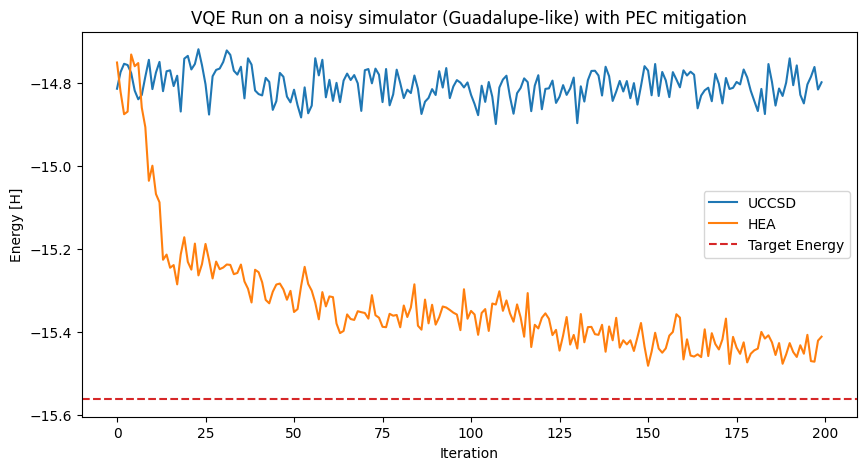

In [177]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(energies_mitigated_uccsd, label="UCCSD")
plt.plot(energies_mitigated_hea, label="HEA")

plt.axhline(y=-15.561353, color="tab:red", ls="--", label="Target Energy")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE Run on a noisy simulator (Guadalupe-like) with PEC mitigation")
plt.show()

The difference between both ansätze remained as expected, although the resul given by the EfficientSU2 ansatz is now much closer to the the actual ground energy.

### Real device (IBMQ Guadalupe)

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum')
service.backends()

In [ ]:
guadalupe = service.backends(name='ibmq_guadalupe')[0]

print(guadalupe)

In [ ]:
def train_remote(problem, observables, ansatz, backend, options, initial_point=None):
    estimator = BackendEstimator(backend=backend, options=options)
    energies = []
    param_history = []
    job_list = []
    prev_jobs = 0
    last_time = time()
    nb_iter = 0
    with Session(service=service, backend=backend) as session: 
    
        def evaluate_expectation(x):
            estimator = Estimator(options=options, session=session)
            x = list(x)
            job = estimator.run(circuits=[ansatz], parameter_values=[x], observables=[observables]).result()
            results = job.values[0]
            job_list.append(job)

            return np.real(results)

        def callback(x, fx, ax, tx, nx):
            nonlocal prev_jobs, last_time, nb_iter

            sol = MinimumEigensolverResult()
            sol.eigenvalue = ax
            energies.append(np.real(problem.interpret(sol).total_energies[0]))
            param_history.append(fx)
            print(f"[{len(energies)}] Current estimate: {energies[-1]:.5f}  Ha")
            prev_jobs = len(job_list)
            last_time = time() 

        if initial_point is None:
            initial_point = np.random.random(ansatz.num_parameters)

        optimizer =  SPSA(maxiter=200, callback=callback)
        result =  optimizer.minimize(evaluate_expectation, x0=initial_point)
   
    return energies, param_history

In [7]:
# energies_real_hea, params_real_hea = train_local(problem, qubit_op, hea_simplified, guadalupe, options, initial_point=None)
# np.save(Path.cwd() / "data" / "energies_real_hea", np.array(energies_real_hea))
energies_real_hea = np.load(Path.cwd() / "data" / "energies_real_hea.npy")

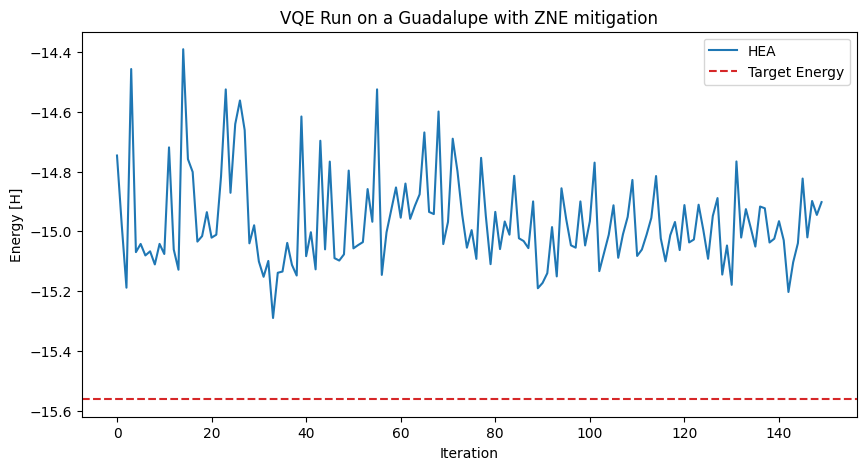

In [8]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(energies_real_hea, label="HEA")

plt.axhline(y=-15.561353, color="tab:red", ls="--", label="Target Energy")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE Run on a Guadalupe with ZNE mitigation")
plt.show()